<a href="https://colab.research.google.com/github/alarcon7a/florence-2-tutorial/blob/main/florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q transformers accelerate timm flash_attn einops

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Cargar el modelo y el procesador
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [ ]:
mara = Image.open('/content/mara.jpeg')
bodegon = Image.open('/content/bodegon.png')

## CAPTION

In [ ]:
task = '<CAPTION>'
inputs = processor(text=task, images=mara, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(mara.width, mara.height))

print(parsed_answer)

{'<CAPTION>': 'A dog wearing a purple shirt laying in the grass.'}


## DETAILED_CAPTION

In [ ]:
task = '<DETAILED_CAPTION>'
inputs = processor(text=task, images=mara, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(mara.width, mara.height))

print(parsed_answer)

{'<DETAILED_CAPTION>': 'The image shows a dog laying in the grass wearing a purple shirt. In the background there are trees, vehicles, buildings, and a clear blue sky.'}


## Creemos una funcion

In [ ]:
def run_example(task_prompt, text_input=None, image=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## MORE_DETAILED_CAPTION

In [ ]:
run_example(task_prompt='<MORE_DETAILED_CAPTION>',image=mara)

{'<MORE_DETAILED_CAPTION>': 'The image shows a yellow Labrador Retriever dog lying on a grassy lawn. The dog is wearing a purple bandana around its neck and is resting its head on its front paws. Its mouth is open and its tongue is sticking out, as if it is panting or panting. In the background, there are trees and a parking lot with cars parked in it. The sky is blue and the weather appears to be sunny.'}

## OD - Object detection

In [ ]:
task_prompt = '<OD>'
results = run_example(task_prompt,image=mara)
print(results)

{'<OD>': {'bboxes': [[250.20001220703125, 300.0, 1121.4000244140625, 1343.2000732421875]], 'labels': ['dog']}}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

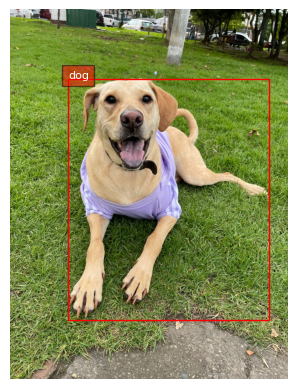

In [ ]:
plot_bbox(mara, results['<OD>'])

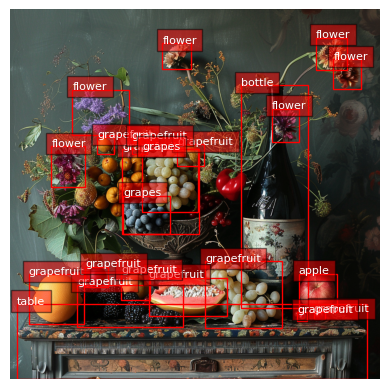

In [ ]:
task_prompt = '<OD>'
results = run_example(task_prompt,image=bodegon)
plot_bbox(bodegon, results['<OD>'])

## DENSE_REGION_CAPTION

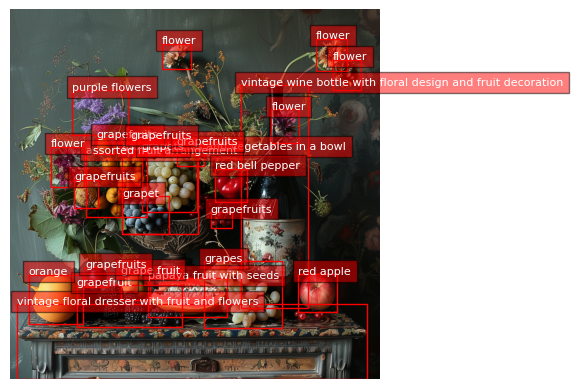

In [ ]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt,image=bodegon)
plot_bbox(bodegon, results['<DENSE_REGION_CAPTION>'])

## CAPTION_TO_PHRASE_GROUNDING

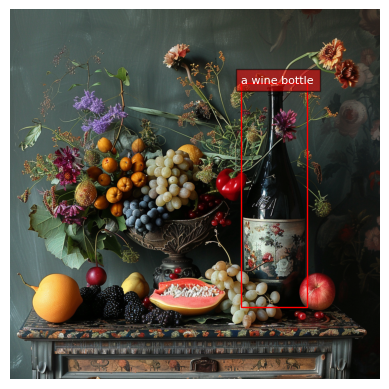

In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="a wine bottle",image=bodegon)
plot_bbox(bodegon, results['<CAPTION_TO_PHRASE_GROUNDING>'])

## Segmentation

In [ ]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a wine bottle",image=bodegon)
results['<REFERRING_EXPRESSION_SEGMENTATION>']

In [ ]:
results

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

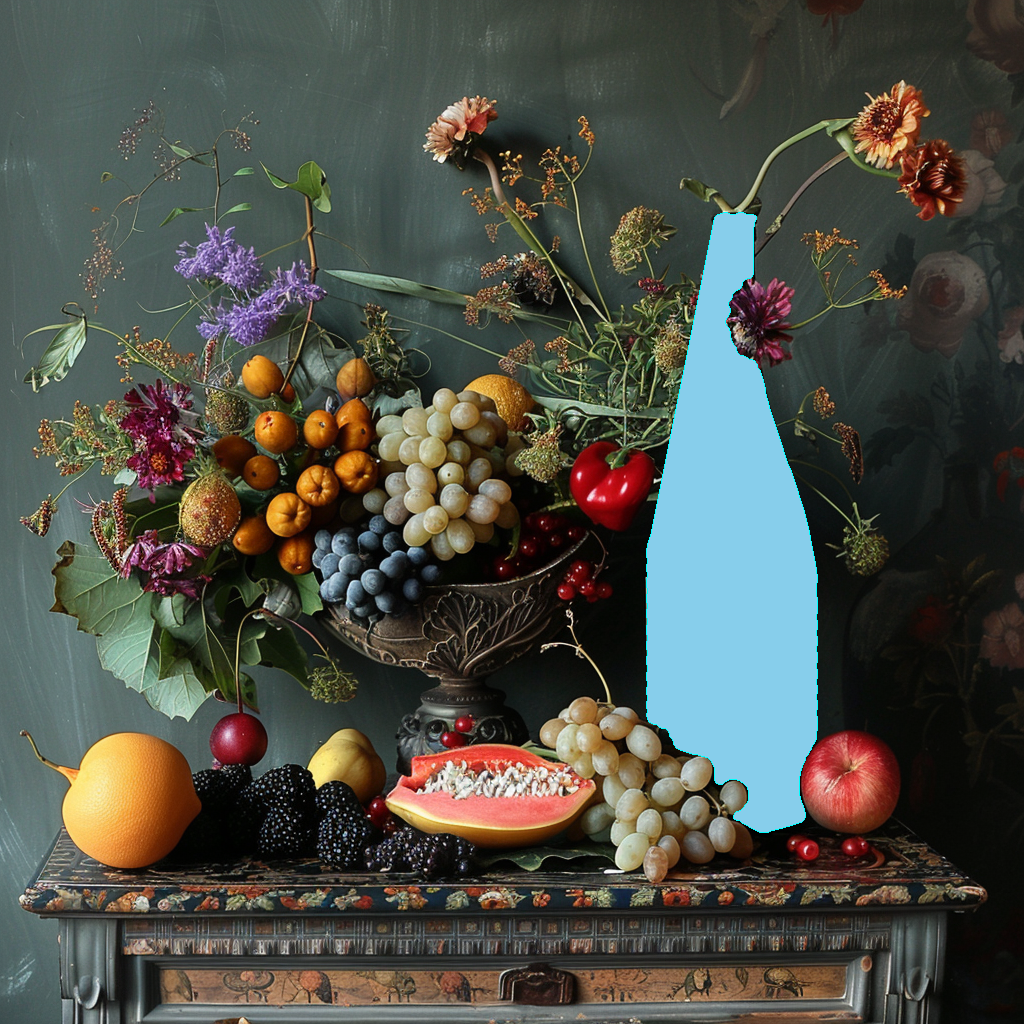

In [ ]:
import copy
output_image = copy.deepcopy(bodegon)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

## Text detection

In [ ]:
flayer = Image.open('/content/AI y Educacion.jpg')

In [ ]:
task_prompt = '<OCR>'
run_example(task_prompt,image=flayer)

{'<OCR>': 'SHAPING THEFUTUREMIT HARVARDCOLOMBIA SUMMIT08 JUNIO 2024 | METROPOLITAN CLUB, BOGOTÁINTELIGENCIA ARTIFICIAL Y LAS NUEVAS REALIDADES DE LA EDUCACIÓNGIOVANNI STELLACLAUDIA RESTREPOCERENTE DE GOOGLE COLOMBIARECTORA UNIVERSIDADMODERA:EAFITUNTOSPOEDEMOSVIVIANA BAYUELOCARLOS ALARCONCONSULTORA TICCONSULTOR EXPERTOLORENZO GARAVITOSOCIO METRIX FINANZASEN IAwww.shapingthefuture.com.coAPOYAN:UNIVERSIDADMARTINEZLATHAM&EAFITMOMENTOAZEWATKINSLLPGlobalEducationMIT - Harvard ClubLAGUADAVivoBANCOLDEXColombiaARIS MINING& DE LA ROSA'}

In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image=flayer)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[512.4600219726562, 62.10000228881836, 773.8200073242188, 62.10000228881836, 773.8200073242188, 89.10000610351562, 512.4600219726562, 89.10000610351562], [426.0600280761719, 94.5, 775.9800415039062, 94.5, 775.9800415039062, 161.4600067138672, 426.0600280761719, 161.4600067138672], [514.6199951171875, 163.62001037597656, 773.8200073242188, 163.62001037597656, 773.8200073242188, 190.62001037597656, 514.6199951171875, 190.62001037597656], [265.1400146484375, 231.66000366210938, 841.8600463867188, 231.66000366210938, 841.8600463867188, 258.6600036621094, 265.1400146484375, 258.6600036621094], [54.540000915527344, 266.2200012207031, 1052.4600830078125, 265.1400146484375, 1052.4600830078125, 295.3800048828125, 54.540000915527344, 296.46002197265625], [306.1800231933594, 902.3400268554688, 770.5800170898438, 902.3400268554688, 770.5800170898438, 933.6600341796875, 306.1800231933594, 934.7400512695312], [778.1400146484375, 981.1800537109375, 902.3400268554

In [ ]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

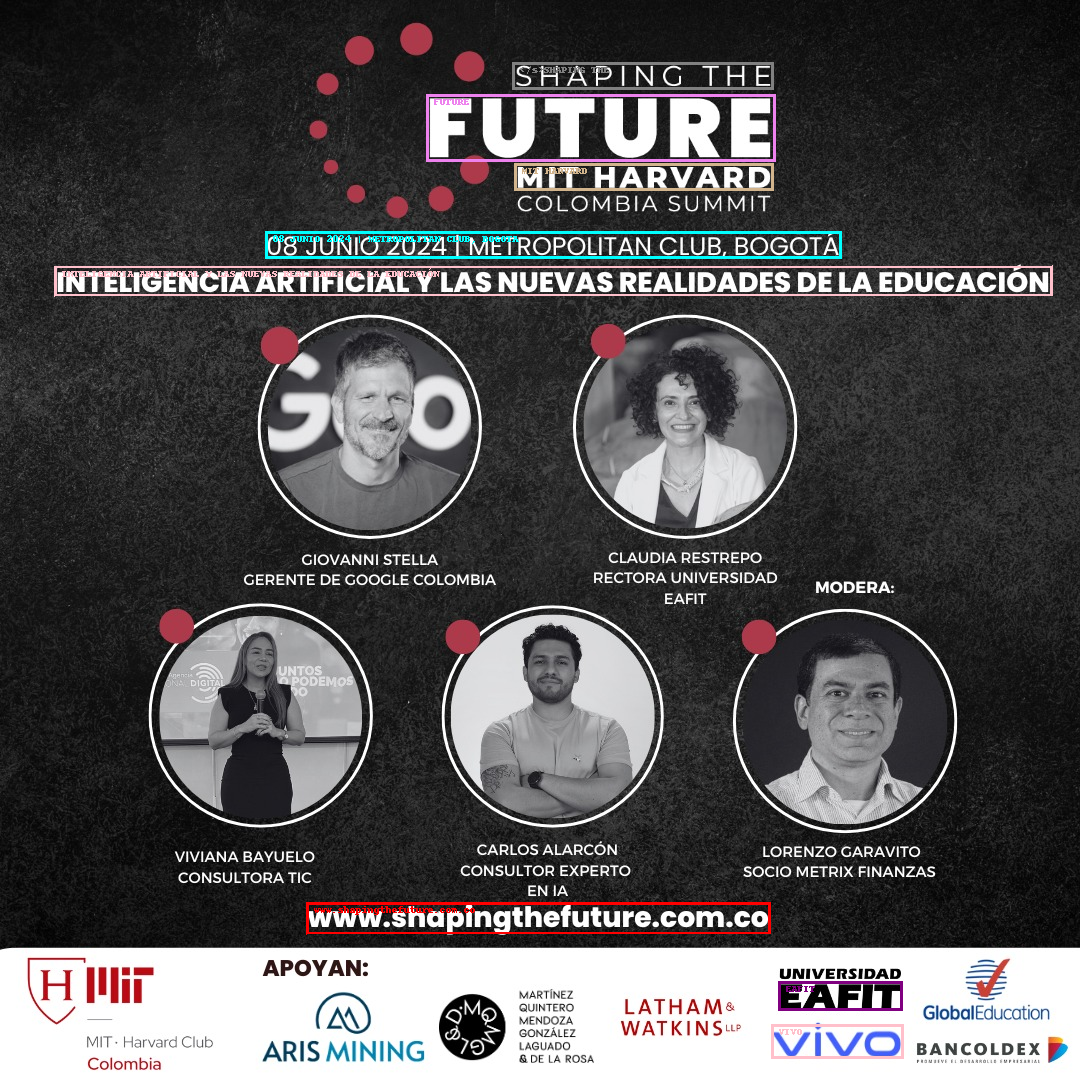

In [ ]:
output_image = copy.deepcopy(flayer)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

## Funciona con un video

In [ ]:
# Configurar el video
video_path = '/content/video.mp4'
output_path = '/content/output.mp4'
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para el archivo de salida
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

prompt = "<OD>"
frame_count = 0

# Variables para almacenar las detecciones del último fotograma procesado
last_bboxes = []
last_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Procesar solo cada 10 fotogramas
    if frame_count % 10 == 0:
        # Convertir el fotograma a una imagen PIL
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Procesar la imagen con Florence-2
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3,
            do_sample=False
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

        # Actualizar las detecciones del último fotograma procesado
        last_bboxes = parsed_answer['<OD>']['bboxes']
        last_labels = parsed_answer['<OD>']['labels']

    # Dibujar las cajas de detección y etiquetas en el fotograma utilizando las últimas detecciones procesadas
    for bbox, label in zip(last_bboxes, last_labels):
        x1, y1, x2, y2 = [int(coord) for coord in bbox]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Escribir el fotograma procesado en el archivo de salida
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"Processed {frame_count // 10} frames and saved to {output_path}")

Processed 57 frames and saved to /content/output.mp4
